# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math
from importlib import reload

In [2]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
#del cwd, path
import KaggleAmazonMain as kam

In [3]:
reload(kam)

<module 'KaggleAmazonMain' from 'C:\\Work\\Kaggle\\Planet\\kaggle_UnderstandingAmazonFromSpace\\develop\\..\\src\\KaggleAmazonMain.py'>

In [9]:
#Load from pickle unless something has changed
X = pd.read_pickle('X_train.pkl')
y = pd.read_pickle('y_train.pkl')
y[y > 1] = 1 #fix labels accidently labels twice. mistake in tagging. oops. 
X_sample, labels, names_train, tagged_df = kam.load_sample_training_data() #load sample data for plotting

cwd C:\Work\Kaggle\Planet\kaggle_UnderstandingAmazonFromSpace\develop
Loading jpg image dataset


There are 17 unique tags in this data


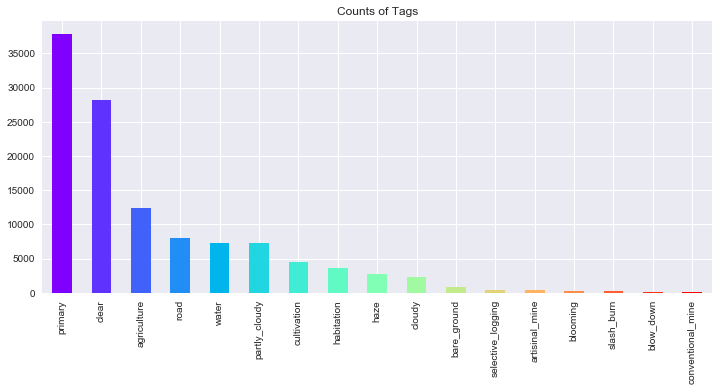

In [11]:
#Barplot of tag counts
%matplotlib inline
def plot_sample_size(tagged_df):
    plt.rcParams['figure.figsize'] = (12, 5)
    print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
    colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
    tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()
plot_sample_size(tagged_df)

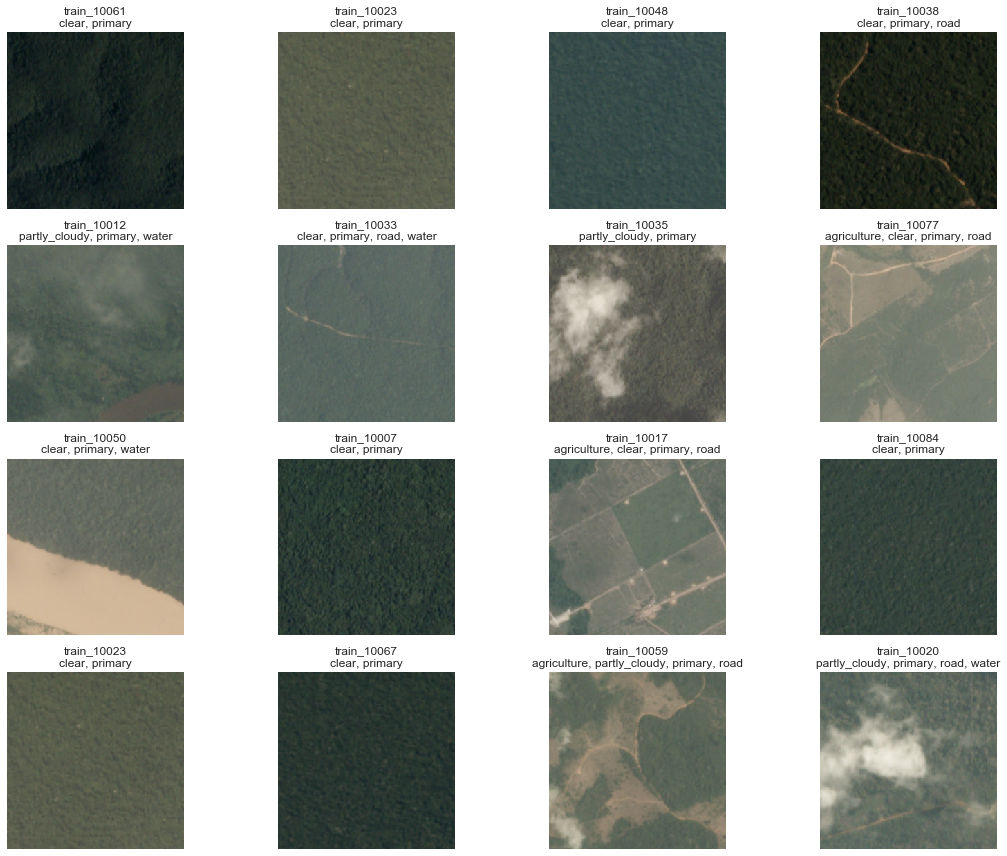

In [12]:
kam.plot_samples(X_sample, names_train, tagged_df, nrow=4, ncol=4)

# Feature Engineering
What type of features are we working with here?
Feature engineering explores the feature data, and does feature creation.
Each image consists of pixel values in red, geen, and blue color schemes. The patterns in these pixels will  have useful trends for classifying the objects in the images and the image types. Notice how the statistical distributions of the red, green, and blue, pixels differ for different types of tags.

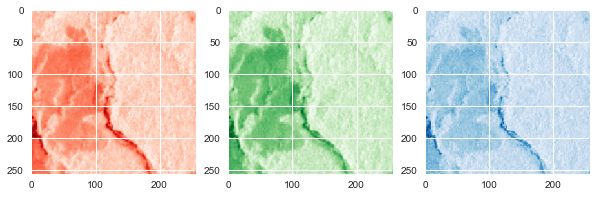

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_sample[1,:,:,0], cmap='Reds')
axes[1].imshow(X_sample[1,:,:,1], cmap='Greens')
axes[2].imshow(X_sample[1,:,:,2], cmap='Blues')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


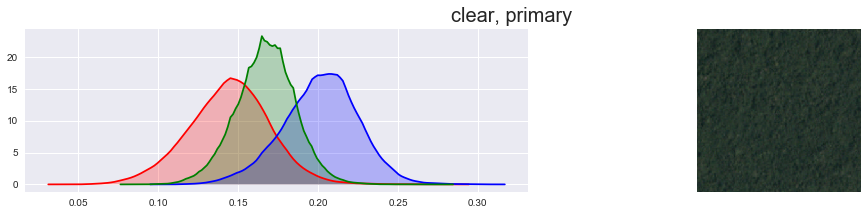

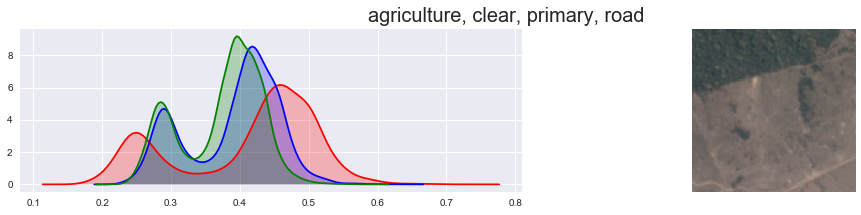

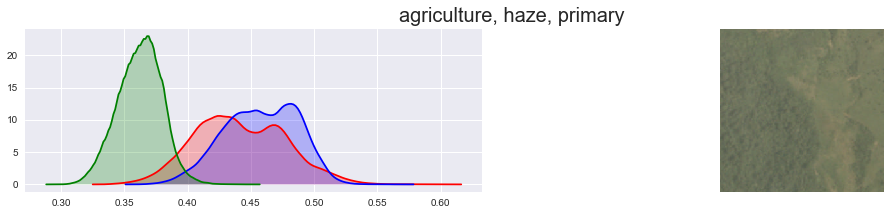

In [16]:
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,3):
    sample = np.random.randint(low=0, high=X_sample.shape[0]-1, size = 1)
    ind = names_train[sample[0]]
    tags = kam.get_labels(ind, tagged_df)
    kam.plot_rgb_dist(X_sample[sample[0],:,:,:],tags)

Create features from the raw pixel data. These metrics should be metrics that describe patterns in the trends and distributions of the pixels. 
Using binned historgram features to capture bimodality and general shape and location of distributions in red, green, and blue.

I want to try an ML algorithm with feature cdreation, and a NN with raw pixel data to compare results. 

binned mode differences is a feature created to discribe bimodal distributions. A lot of the r g b distributions are bimodal, which could offer interesting insight into the  classificatioin, so I created a feature to capture bimodal patterns in the r g b pixel distributions. The binned mode differences is simply the differnce between the two min bounds of the two largest count bins, or the two modes. If this value is large, then the two larges modes are a large distance from eachother, indicating the distribution is bimodal.

The mean of the red distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.16] and [ 0.3]


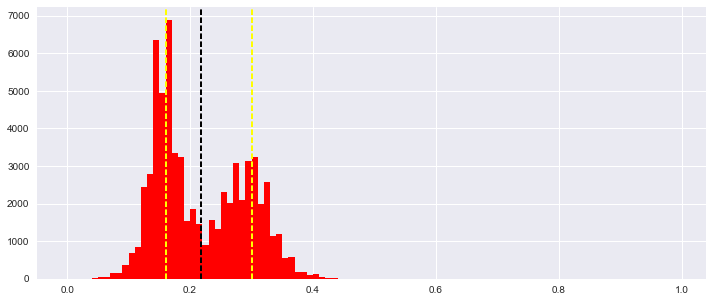

The mean of the green distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.2] and [ 0.27]


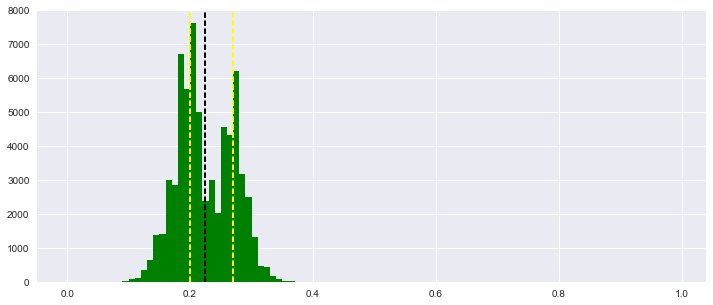

The mean of the blue distribution is 0.2
After splitting on the mean, the two modes are found at [ 0.18] and [ 0.23]


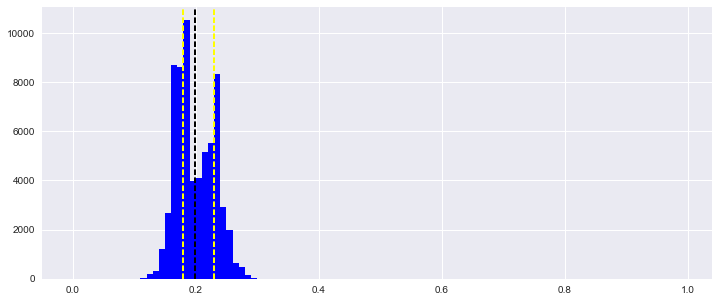

(0.14000000000000001, 0.070000000000000007, 0.050000000000000003)

In [17]:
#Binned mode differences

def binned_mode_features_with_diagnostics(img, steps):
    ## red ##
    #split on mean
    m=img[:,:,0].flatten().mean()
    left = img[:,:,0].flatten()[img[:,:,0].flatten()<m]
    right = img[:,:,0].flatten()[img[:,:,0].flatten()>=m]
    #find mode in left and right
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    #calc bimodal metric
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_r=abs(mo1-mo2)
    print("The mean of the red distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,0].flatten(), color='red', bins=steps)
    plt.axvline(img[:,:,0].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## green ##
    m=img[:,:,1].flatten().mean()
    left = img[:,:,1].flatten()[img[:,:,1].flatten()<m]
    right = img[:,:,1].flatten()[img[:,:,1].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_g=abs(mo1-mo2)
    print("The mean of the green distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,1].flatten(), color='green', bins=steps)
    plt.axvline(img[:,:,1].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## blue ##
    m=img[:,:,2].flatten().mean()
    left = img[:,:,2].flatten()[img[:,:,2].flatten()<m]
    right = img[:,:,2].flatten()[img[:,:,2].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_b=abs(mo1-mo2)
    print("The mean of the blue distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,2].flatten(), color='blue', bins=steps)
    plt.axvline(img[:,:,2].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    return mods_diff_r[0].round(2), mods_diff_g[0].round(2), mods_diff_b[0].round(2)

img=X_sample[2]
steps=np.arange(start=0,stop=1, step=.01)
binned_mode_features_with_diagnostics(img, steps)

Also created sobel features. blah blah blah about those

In [22]:
from skimage.color import rgb2gray
from skimage import transform, img_as_float, filters
X_train_g = rgb2gray(X_sample)

X_train_sobel = []
for i in range(X_train_g.shape[0]):
    X_train_sobel.append(filters.sobel(X_train_g[i]))
X_train_sobel = np.asarray(X_train_sobel)

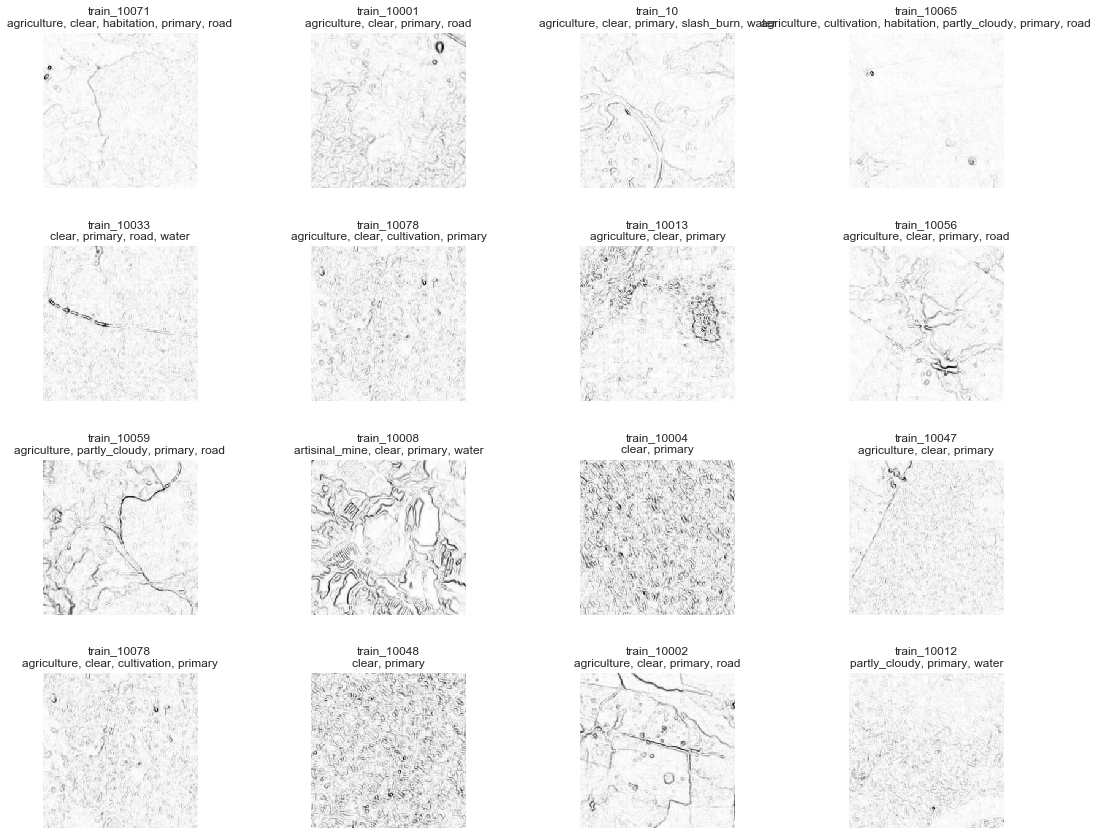

In [23]:
kam.plot_samples(X_train_sobel, names_train, tagged_df, 4,4)

Check out the features that were made... See if they describe separation of  classes. 

Index(['b_bimodal', 'b_kurtosis', 'b_max', 'b_mean', 'b_min', 'b_skew',
       'b_std', 'g_bimodal', 'g_kurtosis', 'g_max', 'g_mean', 'g_min',
       'g_skew', 'g_std', 'r_bimodal', 'r_kurtosis', 'r_max', 'r_mean',
       'r_min', 'r_skew', 'r_std', 'sobel_colmean_std', 'sobel_kurtosis',
       'sobel_max', 'sobel_mean', 'sobel_min', 'sobel_rowmean_std',
       'sobel_skew', 'sobel_std'],
      dtype='object')


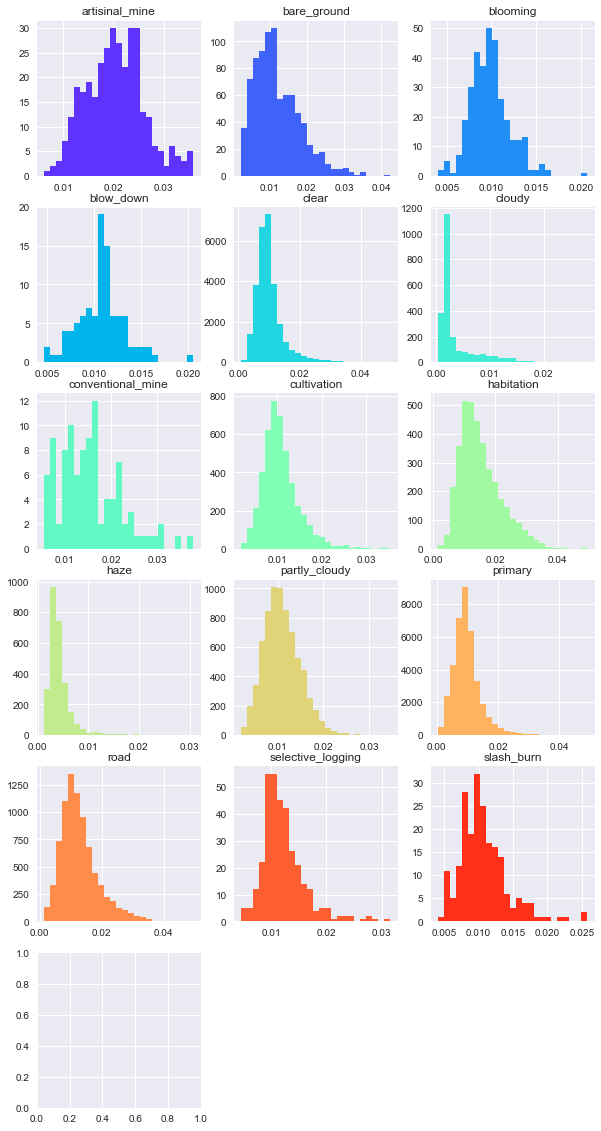

In [24]:
plt.rcParams['figure.figsize'] = (10, 20)

#create table of each feature histograms for each label
X.set_index(y.index, inplace=True)
print(X.columns) #possible features to plot


#function to plot distributions of a featur by class label
def plot_a_feature_by_labels(feature):
    colors = cm.rainbow(np.linspace(0, 1, len(y.columns))) #pick colors for plots by labels
    for i in np.arange(0, len(y.columns)-1):
        col=y.columns[i]
        ind_list = y[y[col]==1].index.tolist()
        X.ix[ind_list][feature].hist(bins=25, color=colors[i])
        plt.title(col)
        plt.grid(True)
        plt.subplot(6,3,i+1) 
        #plt.xlim(0,X_train[feature].max())
        #plt.axvline(X_train[feature].mean(), color='black', linestyle='dashed', linewidth=2) #fix this to plot mean 
    
        
#plot_a_feature_by_labels('b_bimodal')        
plot_a_feature_by_labels('sobel_colmean_std')

# Random Forest

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113)

In [26]:
y.sum() #these are the sample sizes per class

agriculture          12338
artisinal_mine         339
bare_ground            859
blooming               332
blow_down               98
clear                28203
cloudy                2330
conventional_mine      100
cultivation           4477
habitation            3662
haze                  2695
partly_cloudy         7251
primary              37840
road                  8076
selective_logging      340
slash_burn             209
water                 7262
dtype: int64

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

In [28]:
rf.fit(X_train, y_train)
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(2)))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=14113, verbose=0,
            warm_start=False)

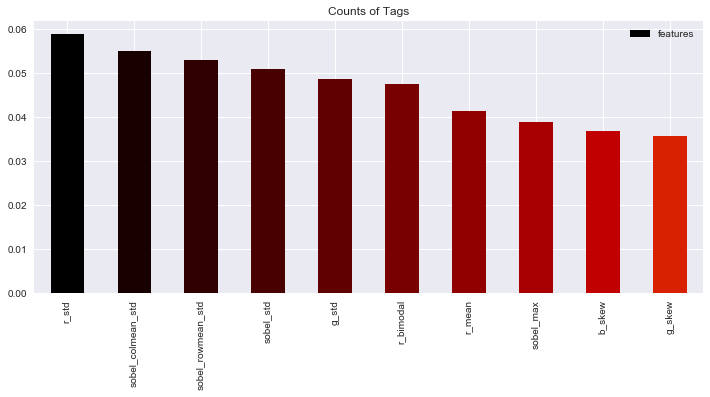

In [38]:
#features ranking of features. 

Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
def plot_feature_importance(Feature_importance, n):
    '''
    plot top n features
    '''
    plt.rcParams['figure.figsize'] = (12, 5)
    Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
    Feature_importance.columns = ['features']
    Feature_importance = Feature_importance.sort_values(by='features', axis=0, ascending=False)
    colors = cm.gist_heat(np.linspace(0, 1, len(tagged_df.columns)))
    Feature_importance.head(n).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()

plot_feature_importance(Feature_importance, 10)


## F2-score and other metrics

In [39]:
from sklearn.metrics import fbeta_score
np.asarray(y_validation)

predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.8370163549164279

precision is  of the imgaes taggd with a particular class, how many times that was the right class. 
recall is of the images of a certain class, how many we correctly identified as that class. 
f score is a blah average of precision and recall. 
support is the same size of images with that label in the training data. 
blah blah blah add descriptions of these metrics 

In [40]:
#calc some other scoring metrics. precision, recall, and f1.
#The confusion matrix is diddicult to make and read for miltilabel classificatoin, but this table shows the same information 
#it shows the classes the model is perfomring well and poorly on.
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation.columns
Metrics

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.794624,0.970588,1.000000,0.0,0.0,0.937878,0.850192,0.0,0.676364,0.805369,0.780987,0.926775,0.970510,0.754006,0.0,0.0,0.795229
recall,0.740926,0.235714,0.005634,0.0,0.0,0.965777,0.761468,0.0,0.103448,0.392927,0.580501,0.748753,0.992084,0.576240,0.0,0.0,0.272387
support,4987.000000,140.000000,355.000000,133.0,46.0,11396.000000,872.000000,44.0,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,140.0,86.0,2937.000000


## Diagnostics

In [41]:
probs = rf.predict_proba(X_validation)

ROC curves visualize performance of a class/binary classifier. Visualization of how predicted probabilities compare to the truth. 

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


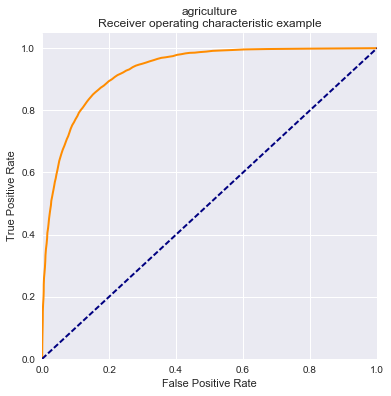

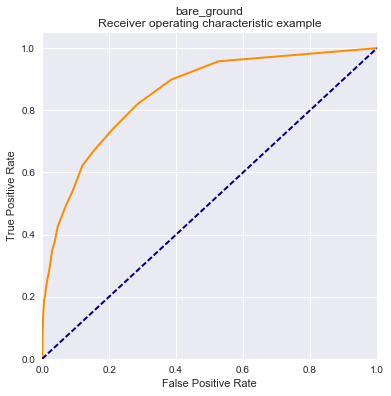

In [117]:
from sklearn import metrics

def plot_ROC(tag):
    '''
    plot ROC curve for a specific tag
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    n = np.where(y_validation.columns==tag)[0][0]
    fpr, tpr, threshs = metrics.roc_curve(y_validation[tag], probs[n][:,1],
                                          pos_label=None, sample_weight=None, drop_intermediate=False)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tag+'\nReceiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
plot_ROC('agriculture')
plot_ROC('bare_ground')

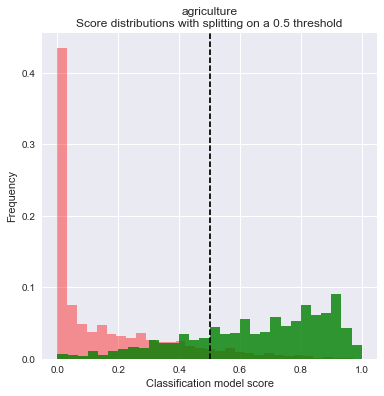

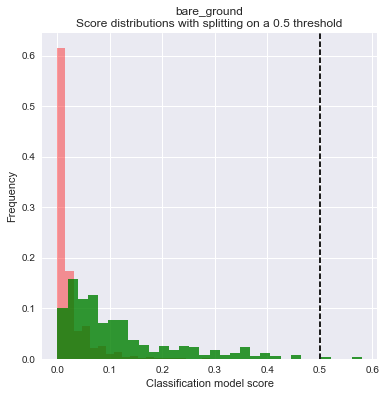

In [151]:
def plot_decision_hist(tag):
    '''
    plots decision histograms with thresholds
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    #Less than .5 is 0. greater is 1
    n = np.where(y_validation.columns==tag)[0][0]
    probs_df = pd.DataFrame(probs[n][:,1]).set_index(y_validation[tag])
    class0 =  np.array(probs_df.ix[0][0]) #0 does not have true tag
    class1 =  np.array(probs_df.ix[1][0]) #1 does have true tag

    S = class0
    # Histogram:
    # Bin it
    n, bin_edges = np.histogram(S, 30)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, color='red', alpha=.4)

    S = class1
    n, bin_edges = np.histogram(S, 30)
    bin_probability = n/float(n.sum())
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    bin_width = bin_edges[1]-bin_edges[0]
    plt.bar(bin_middles, bin_probability, width=bin_width, color='green', alpha=.8)

    plt.axvline(x=0.5, color='k', linestyle='--')
    plt.title(tag+'\nScore distributions with splitting on a 0.5 threshold')
    plt.xlabel('Classification model score')
    plt.ylabel('Frequency')
    plt.show()
    
plot_decision_hist('agriculture')
plot_decision_hist('bare_ground')    

In [ ]:
#Path forward
#Need to do upsampling and downsampling to handel these class impalance. done
#set threshold.  
#create more features. done

The imbalanced-learn library imblearn has great modules for oversampling. WE are usign oeversampling because undersampling leads to loss of information, and some classes are very small so it would also lead to a very small dataset. Note oversampling can lead to overfitting the samller classes... Didn't work with multiclasses. I wrote my oen function for oversampling. It oversamples classes smaller than l up to size l by repeating a relabeled image the same as the randomly sampled image. 

In [170]:
l=10000
print(len(y['bare_ground']))

cols=y.sum()[y.sum()<l].index
y.sum()


40479


agriculture          12338
artisinal_mine         339
bare_ground            859
blooming               332
blow_down               98
clear                28203
cloudy                2330
conventional_mine      100
cultivation           4477
habitation            3662
haze                  2695
partly_cloudy         7251
primary              37840
road                  8076
selective_logging      340
slash_burn             209
water                 7262
dtype: int64

In [171]:
#randomly over sample

def over_sample(X, y, l):
    '''
    resamples classes smaller than l to be size l
    '''
    y_upsampled=y.copy()
    X_upsampled=X.copy()
    cols=y.sum()[y.sum()<l].index #classes with less than l samples.
    for c in cols:
        I_y = y[y[c]==1].sample(n=l-len(y[c]), replace=True)
        x_index = I_y.index #index of image names
        I_y.reset_index(drop=True, inplace=True) #rename y index
        y_upsampled = y_upsampled.append(I_y, )
        
        I_x = X.loc[x_index]
        I_x.reset_index(drop=True, inplace=True) #rename y index
        X_upsampled = X_upsampled.append(I_x, )

    return X_upsampled, y_upsampled

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113)
X_upsampled, y_upsampled = over_sample(X=X_train, y=y_train, l=10000)

ValueError: A negative number of rows requested. Please provide positive value.

In [ ]:
y_sampled.sum()

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

rf.fit(X_sampled, y_sampled)
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(5)))

The oob error for this random forest is 0.99968


In [38]:
from sklearn.metrics import fbeta_score

predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.8419241410341668

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation.columns
Metrics

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.789441,0.927273,0.375000,0.0,0.0,0.944181,0.84769,1.000000,0.640587,0.783654,0.761326,0.922514,0.971371,0.744600,1.000000,0.0,0.762712
recall,0.755564,0.364286,0.008451,0.0,0.0,0.960337,0.77867,0.022727,0.145717,0.426981,0.616279,0.763721,0.991491,0.601653,0.007143,0.0,0.291113
support,4987.000000,140.000000,355.000000,133.0,46.0,11396.000000,872.00000,44.000000,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,140.000000,86.0,2937.000000
